In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from skimage import io
from sklearn.model_selection import train_test_split

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms
from torchvision.utils import make_grid, save_image

print('PyTorch version:', torch.__version__)
print('torchvision version:', torchvision.__version__)
use_gpu = torch.cuda.is_available()
print('Is GPU available:', use_gpu)

PyTorch version: 0.4.1
torchvision version: 0.2.1
Is GPU available: True


In [2]:
# general settings

# device
device = torch.device('cuda' if use_gpu else 'cpu')

# batchsize
batchsize = 5

# imagesize for random crop
imagesize = 256

# seed setting (warning : cuDNN's randomness is remaining)
seed = 1
torch.manual_seed(seed)
if use_gpu:
    torch.cuda.manual_seed(seed)
    
# directory settings
# data directory
root_dir = '../../data/200003076/'
image_dir = root_dir + 'images_resized_1024/'
label_dir = root_dir + 'labels_resized_1024/one_x0.8/'

# directory to put generated images
output_dir = root_dir + 'output_resized_1024(croped_512)_one_x0.8/'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
    
# directory to save state_dict and loss.npy
save_dir = root_dir + 'save_resized_1024(croped_512)_one_x0.8/'
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

In [4]:
# make dataset class for image loading
class MyDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform_image = None, transform_label = None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        
        self.image_list = os.listdir(image_dir)
        self.label_list = os.listdir(label_dir)
        
        self.transform_image = transform_image
        self.transform_label = transform_label
        
    def __len__(self):
        return len(self.image_list)
    
    def __getitem__(self, idx):
        image_name = self.image_dir + self.image_list[idx]
        label_name = self.label_dir + self.label_list[idx]
        
        image = Image.open(image_name) # io.imread(image_name)
        label = Image.open(label_name) # io.imread(label_name)
        
        if self.transform_image:
            image = self.transform_image(image)
            
        if self.transform_label:
            label = self.transform_label(label)
            
        return image, label

In [34]:
# define transform
# Normalize [0~255] to [0~1]
class Normalize:
    def __call__(self, image):
        return image / 255
    
class Add_dim:
    def __call__(self, label):
        return label.reshape(label.shape[0], label.shape[1], 1)
    
class Tofloat:
    def __call__(self, tensor):
        return tensor.float()
    
tf_image = transforms.Compose([transforms.RandomCrop(512), transforms.ToTensor()])#, Normalize()])
tf_label = transforms.Compose([transforms.RandomCrop(512), transforms.ToTensor()])

In [35]:
# make dataset
imgDataset = MyDataset(image_dir, label_dir, transform_image = tf_image, transform_label = tf_label)

# split to train data and validation data
train_data, validation_data = train_test_split(imgDataset, test_size = 0.2, random_state = seed)

print('The number of training data:', len(train_data))
print('The number of validation data:', len(validation_data))

The number of training data: 276
The number of validation data: 70


In [36]:
# make DataLoader
train_loader = DataLoader(train_data, batch_size = batchsize, shuffle = True)
validation_loader = DataLoader(validation_data, batch_size = batchsize, shuffle = True)

torch.Size([5, 3, 512, 512])
torch.Size([5, 1, 512, 512])


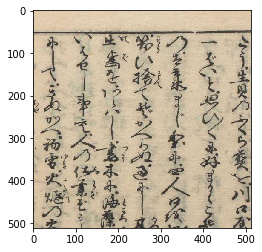

In [38]:
train_tensor = iter(train_loader).next()
print(train_tensor[0].shape)
print(train_tensor[1].shape)
plt.imshow(np.transpose(train_tensor[0][2], [1,2,0]))

In [45]:
print(train_tensor[0][3].max())

tensor(0.9412)


In [0]:


# define parts for U-net for convenience
# downsampling
# conv > batchnorm > dropout > leakyrelu
class Downsample(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size = 4 , stride = 2, padding = 1,                                                                     use_batchnorm = True, use_dropout = False):
        super(Downsample, self).__init__()
        self.cv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.dr = nn.Dropout(0.5)
        self.rl = nn.LeakyReLU(0.2)
        
        self.use_batchnorm = use_batchnorm
        self.use_dropout = use_dropout
        
    def forward(self, x):
        out = self.cv(x)
        
        if self.use_batchnorm:
            out = self.bn(out)
            
        if self.use_dropout:
            out = self.dr(out)
            
        out = self.rl(out)
        
        return out



In [0]:


# define parts for U-net for convenience
# upsampling (using transposed convolution)
# conv > batchnorm > dropout > relu
class Upsample(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size = 4, stride = 2, padding = 1,                                                                    use_batchnorm = True, use_dropout = False):
        super(Upsample, self).__init__()
        self.tc = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.dr = nn.Dropout(0.5)
        self.rl = nn.ReLU()
        
        self.use_batchnorm = use_batchnorm
        self.use_dropout = use_dropout
        
    def forward(self, x):
        out = self.tc(x)
        
        if self.use_batchnorm:
            out = self.bn(out)
            
        if self.use_dropout:
            out = self.dr(out)
            
        out = self.rl(out)
        
        return out



In [0]:


''' Memo : CNN size equation (no dilation)

                                OUT = (IN + 2*Padding - Kernel_size) / Stride + 1                 
'''
# U-net architecture
class U_net(nn.Module):
    def __init__(self):
        super(U_net, self).__init__()
        
        # U-net encoder
        # default: kernel_size = 4, stride = 2, padding = 1, using batchnorm, no dropout
        self.encoder1 = Downsample(  3,    64, use_batchnorm = False)   # out tensor size: (batchsize,   64, 256, 256)
        self.encoder2 = Downsample( 64,   128)                          # out tensor size: (batchsize,  128, 128, 128)
        self.encoder3 = Downsample(128,   256)                          # out tensor size: (batchsize,  256,  64,  64)
        self.encoder4 = Downsample(256,   512)                          # out tensor size: (batchsize,  512,  32,  32)
        self.encoder5 = Downsample(512,   512)                          # out tensor size: (batchsize,  512,  16,  16)
        self.encoder6 = Downsample(512,   512)                          # out tensor size: (batchsize,  512,   8,   8)
        self.encoder7 = Downsample(512,   512)                          # out tensor size: (batchsize,  512,   4,   4)
        self.encoder8 = Downsample(512,   512)                          # out tensor size: (batchsize,  512,   2,   2)
        self.encoder9 = Downsample(512,  1024, use_batchnorm = False)   # out tensor size: (batchsize, 1024,   1,   1)



        
        # U-net decoder
        # default: kernel_size = 4, stride = 2, padding = 1, using batchnorm, no dropout
        self.decoder1 = Upsample(1024    , 1024, use_dropout = True)     # out tensor size: (batchsize, 1024,   2,   2)
        self.decoder2 = Upsample(1024+512, 1024, use_dropout = True)     # out tensor size: (batchsize, 1024,   4,   4)
        self.decoder3 = Upsample(1024+512, 1024, use_dropout = True)     # out tensor size: (batchsize, 1024,   8,   8)
        self.decoder4 = Upsample(1024+512, 1024)                         # out tensor size: (batchsize, 1024,  16,  16)
        self.decoder5 = Upsample(1024+512, 1024, use_dropout = False)    # out tensor size: (batchsize, 1024,  32,  32)
        self.decoder6 = Upsample(1024+512, 1024)                         # out tensor size: (batchsize, 1024,  64,  64)
        self.decoder7 = Upsample(1024+256,  512)                         # out tensor size: (batchsize,  512, 128, 128)
        self.decoder8 = Upsample( 512+128,  256, use_dropout = False)    # out tensor size: (batchsize,  256, 256, 256)
        self.decoder9 = Upsample( 256+ 64,  128)                         # out tensor size: (batchsize,  128, 512, 512)
        
        # pointwise convolution to adjust channel with no image size change
        self.decoder10 = nn.Sequential(
                            nn.Conv2d(128, 64, kernel_size = 1, stride = 1, padding = 0),
                            nn.BatchNorm2d(64),
                            # nn.Dropout(0.3),
                            nn.ReLU(),
                            nn.Conv2d(64, 32, kernel_size = 1, stride = 1, padding = 0),
                            nn.BatchNorm2d(32),
                            # nn.Dropout(0.2),
                            nn.ReLU(),
                            nn.Conv2d(32, 1, kernel_size = 1, stride = 1, padding = 0),
                            nn.Sigmoid()
        )
        
    def forward(self, x):
        # encoding part
        out_encoder1 = self.encoder1(x)
        out_encoder2 = self.encoder2(out_encoder1)
        out_encoder3 = self.encoder3(out_encoder2)
        out_encoder4 = self.encoder4(out_encoder3)
        out_encoder5 = self.encoder5(out_encoder4)
        out_encoder6 = self.encoder6(out_encoder5)
        out_encoder7 = self.encoder7(out_encoder6)
        out_encoder8 = self.encoder8(out_encoder7)
        out_encoder9 = self.encoder9(out_encoder8)
        
        # decording part
        out_decoder1 = self.decoder1(out_encoder9)
        out_decoder2 = self.decoder2(torch.cat([out_decoder1, out_encoder8], dim = 1))
        out_decoder3 = self.decoder3(torch.cat([out_decoder2, out_encoder7], dim = 1))
        out_decoder4 = self.decoder4(torch.cat([out_decoder3, out_encoder6], dim = 1))
        out_decoder5 = self.decoder5(torch.cat([out_decoder4, out_encoder5], dim = 1))
        out_decoder6 = self.decoder6(torch.cat([out_decoder5, out_encoder4], dim = 1))
        out_decoder7 = self.decoder7(torch.cat([out_decoder6, out_encoder3], dim = 1))
        out_decoder8 = self.decoder8(torch.cat([out_decoder7, out_encoder2], dim = 1))
        out_decoder9 = self.decoder9(torch.cat([out_decoder8, out_encoder1], dim = 1))
        
        out = self.decoder10(out_decoder9)
        
        return out



In [0]:


# network, optimizer and hyperparameters settings

# instantiate networks
u_net = U_net()

# send to GPU(CPU)
u_net = u_net.to(device)

# set optimizer
u_net_optimizer = optim.Adam(u_net.parameters(), lr = 0.0002) #, betas = [0.5, 0.999])

# init weights
for p in u_net.parameters():
    nn.init.normal_(p, mean = 0, std = 0.02)

# count the number of trainable parameters
num_trainable_params_u_net = sum(p.numel() for p in u_net.parameters() if p.requires_grad)



In [0]:


# print settings
print('U-net')
print('The number of trainable parameters:', num_trainable_params_u_net)
print('\nModel\n', u_net)
print('\nOptimizer\n', u_net_optimizer)



In [0]:


def train(data_loader):
    u_net.train()
    
    running_loss = 0
    
    for inputs, labels in data_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # calculate network outputs
        outputs = u_net(inputs)
        
        # calculate loss function, run backward calculation, and update weights
        u_net_optimizer.zero_grad()
        u_net_loss = F.binary_cross_entropy(outputs, labels)
        u_net_loss.backward()
        u_net_optimizer.step()
        
        running_loss += u_net_loss.item()
        
    # devide by len(data_loader) because F.smooth_l1_loss is normalized in minibatch
    loss = running_loss / len(data_loader)
    
    return loss



In [0]:


n_save_images = 5
interval_save_images = 5 # epoch

def validation(data_loader, epoch):
    u_net.eval()
    
    running_loss = 0
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # calculate network outputs
            outputs = u_net(inputs)
            
            running_loss += F.binary_cross_entropy(outputs, labels).item()

            
    # save [n_save_images] (input, label, output) comparison image
    if epoch % interval_save_images == 0:
        for n in range(n_save_images):
            input_image = inputs[n] # .unsqueeze(0)
            label = labels[n].unsqueeze(0)
            output = outputs[n].unsqueeze(0)
            comparison = torch.cat([label, output])
            save_image(input_image.data.cpu(), '{}/input_{}_{}.png'.format(output_dir, epoch, n))
            save_image(comparison.data.cpu(), '{}/label_output_{}_{}.png'.format(output_dir, epoch, n))
                    
    
    loss = running_loss / len(data_loader)

    return loss



In [0]:


n_epochs = 0
train_loss_list = []
validation_loss_list = []

for epoch in range(n_epochs):
    train_loss = train(train_loader)
    validation_loss = validation(validation_loader, epoch)
    
    train_loss_list.append(train_loss)
    validation_loss_list.append(validation_loss)
    
    print('epoch[%d/%d] train_loss:%1.4f validation_loss:%1.4f' % (epoch+1, n_epochs, train_loss, validation_loss)) 

# save state_dicts
torch.save(u_net.state_dict(), save_dir + 'u_net_' + str(epoch) + '.pth')
torch.save(u_net_optimizer.state_dict(), save_dir + 'u_net_optmizer_' + str(epoch) + '.pth')

# save learning log
np.save(save_dir + 'train_loss_list.npy', np.array(train_loss_list))
np.save(save_dir + 'validation_loss_list.npy', np.array(validation_loss_list))

